# Tutorial 1 - WaveBot
The goal of this tutorial is to show a simple example of the inner optimization loop in WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 
The goal is to **find the optimal PTO force time-series** that produce the most energy subject to a maximum force the PTO can excert.

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

We will start by loading the neccessary modules and creating a save directory:

* Set the logging level (optional) to control the ammount of information printed to the screen
* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 
* Create the *save* directory if it doesn't exist

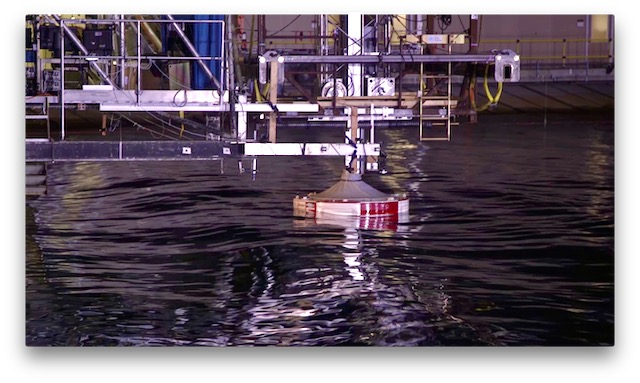

In [1]:
# logging
import logging
logging.basicConfig(level=logging.INFO)

# autograd (derivatives)
import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict

# other packages
import os

import capytaine as cpy
import matplotlib.pyplot as plt
import xarray as xr

# wecopttool
import wecopttool as wot

# create save directory
results_dir = 'results_tutorial_1'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Problem setup
The problem is defined in three parts: the WEC object, the wave spectrum, and the objective function that we are optimizing for. 

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics.
This includes the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2000 N$.
Note that the BEM solution is not reuqired when creating the WEC object, it can be calculated or read after the WEC is created.
WecOptTool uses Capytaine as a BEM solver, and one of the first things we will do is create a Capytaine FloatingBody. 

First, we will create a surface mesh for the hull using an existing function (note, you can use existing STL files, etc.).

In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

From this mesh, we can create a Capytaine floating body, which captures both the mesh and degrees of freedom. We will only model the HEAVE degree of freedom in this case.

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.


At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

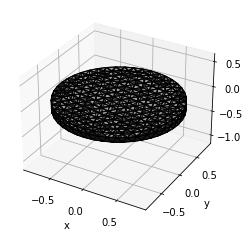

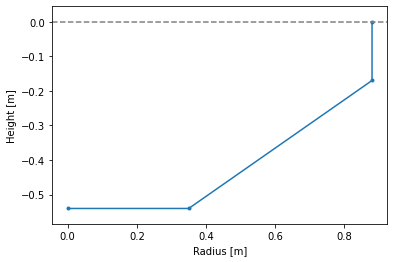

In [4]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

Next we will add the mass and hydrostatic properties. 
If these values are known they can be added directly. H
Here we will use the fact that the WaveBot is free floating and assume constatn density to calculate these properties. 
Capytaine does not (yet) natively perform hydrostatic calculations. 
We can use `meshmagick` to do this, which has been wrapped for convenience in `wecopttool.hydrostatics`. 

In [5]:
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

Next, we will define the frequencies to be considered for the pseudo-spectral problem. 
We will use 50 frequencies with a spacing of 0.05 Hz. 
These frequencies will be used for the Fourier representation of both the wave (and wave excitation force, BEM) and the desired PTO force. 
See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation. 

In [6]:
f0 = 0.05
nfreq = 50

In general, the optimization state and objective function can be anything of interest, and the additional dynamic forces and constraint are also arbitrary. 
In this case the optimization state is the PTO force time-history (Fourier representation), the PTO force will be used as an additional force in the dynamics and will be constrained, and the average PTO power will be the optimization objective function.
WecOptTool includes these functions for this specific case in the `wecopttool.pto` submodule. 
For different optimization state, objective function, dynamic forces, and constraints you will have to write your own function. 

In this case all the functions of interest are packaged into a class called `PseudoSpectralPTO`. 
We will start by creating an instance of this class which requires the number of frequencies in the pseudo-spectral problem and a `kinematics` matrix. 
The kinematics matrix converts from the WEC degrees of freedom (in this case only heave) to the PTO degrees of freedom. 
In this case the PTO extracts power directly from the WEC's heave so the kinemaitcs matrix is simply the $1\times 1$ identity matrix. 

In [7]:
kinematics = np.eye(fb.nb_dofs)
pto = wot.pto.PseudoSpectralPTO(nfreq, kinematics)

Next we will create the constraints, which must be in the correct format for [`scipy.optimize.minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 
We will constraint the PTO force to $2000 N$ in either direction. 
We will enforce the constraint at 4 times more points than the dynamics (see theory section for why this is helpful for the psuedo-spectral problem). 
This will be the only constraint.

We will also create the additional dynamics forces function, which will simply be the PTO force.

In [8]:
# constraints
f_max = 2000.0
nsubsteps = 4


def const_f_pto(wec, x_wec, x_opt):
    f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
    return f_max - np.abs(f.flatten())


ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

# additional dynamics forces function
f_add = pto.force_on_wec

We are now ready to create the WEC object! 

In [9]:
wec = wot.WEC(fb, mass, stiffness, f0, nfreq, 
              f_add=f_add, constraints=constraints)

INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.


Finally, we will now calculate the BEM coefficients by running Capytaine.
If you have already ran the BEM the results will be read instead.
We can review the results by plotting the impedance.

INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, radiating_dof=HEAVE, rho=1025.0).
INFO:capytaine.

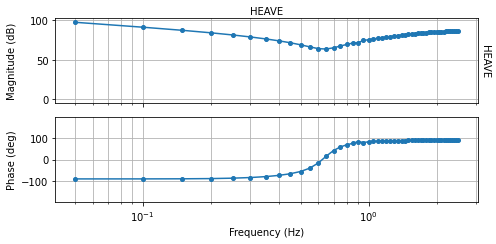

In [10]:
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)
    
_ = wec.plot_impedance()  # see function doc for options

### Waves
The wave environment must be specified as an `xarray.Dataset` containing two 2-dimensional `xarray.DataArray`: (1) the amplitude spectrum  magnitude ``S``
(m^2*s) and (2) the phase ``phase`` (rad). 
The two coordinates are the wave frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.Dataset` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

Now we may create a regular wave using the `wecopttool.waves` submodule. In this case, we will use a wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m.

In [11]:
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

### Objective function
The objective function is the quantity (scalar) we want to optimize. 
It is function of both the WEC dynamics state and the user-defined optimization state. 
We will need to give the solver the objective function to optimize and the size of the optimization state. 
In this case these are the average PTO power and the number of Fourier coefficients in the pseudo-spectral representation of the PTO force, respectively. 
We can get both of these from the PTO object we created.

In [12]:
obj_fun = pto.average_power
nstate_opt = pto.nstate

## Solve
Now we can solve for the optimal PTO force, subject to the dynamics and our additional constraint (no more than $2000 N$ force). 
WecOptTool will solve the optimization problem (PTO force that will produce the highest average power) while simultaneously ensuring the dynamics equation is satisfied.  

To help the optimization we will scale the problem before solving it (see Documentation). 
WecOptTool allows you to scale the WEC dynamics state (see Documentation), your optimization state (in this case the Fourirer coefficients for the PTO force), and the objective function separately. 
See the `wecopttool.WEC.solve()` function for more information. 
Here we are scaling the optimization state by a factor of $0.01$ which results in over $10\times$ less iterations required for the optimizer to converge.

In [13]:
scale_x_wec = 1.0
scale_x_opt = 0.01
scale_obj = 1.0

We are now ready to solve the problem. 
Note that we can pass additional options to the optimizer. 
For more details see `scipy.optimize.minimize`. 
Also note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. 
All other inputs are used to control the optimization execution. 
Pay attention to the `Exit mode`: an exit mode of $0$ indicates a succesful solution. 
See `scipy.optimize.minimize` for more information. 

In [14]:
%%time
options = {'maxiter': 1000, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options, 
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -103.18562473774917
            Iterations: 30
            Function evaluations: 34
            Gradient evaluations: 30
CPU times: user 17.4 s, sys: 2.75 s, total: 20.2 s
Wall time: 5.3 s


As a final step, we post-process the optimized PTO results. 
The included PTO class has a function to postprocess the raw optimized state (PTO force Fourier coefficients) to quantities of interest (e.g. force, power) in both the time- and frequency-domain as an `xarray.Dataset`. 
For different optimization states, you will have to do your own post-processing. 

In [15]:
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

## Results
In this section we will save, view, and plot the results.

In [16]:
# print
print(f"Average power: {obj} W\n")

# save
fname = os.path.join(results_dir, 'wec_tdom.nc')
wec_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'wec_fdom.nc')
wot.complex_xarray_to_netcdf(fname, wec_fdom)

fname = os.path.join(results_dir, 'pto_tdom.nc')
pto_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'pto_fdom.nc')
wot.complex_xarray_to_netcdf(fname, pto_fdom)

Average power: -103.18562473774917 W



### Plotting with xarray
The `xarray` wrapper on `matplotlib.pyplot.plot()` makes it easy to plot the results quickly. 
It sets labels and titles automatically based on the metadata stored in the array. 

We will first look at some time-domain solutions. 
We will only plot a subset of the available quantities; inspect the `xarray.Dataset` objects for all stored quantities. 

Note that the PTO force never exceeds $2000N$, and that due to the non-linear constraint the WEC heave motion is not sinusiodal. 

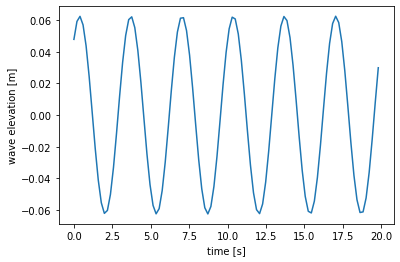

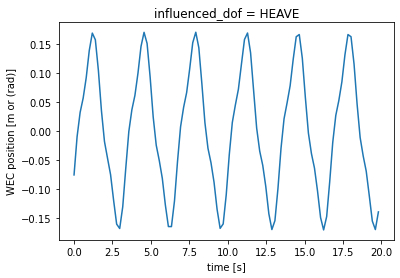

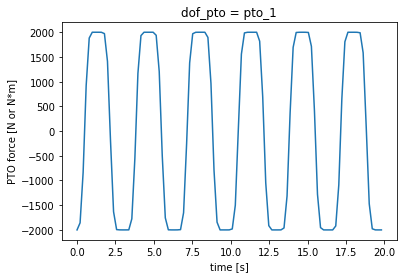

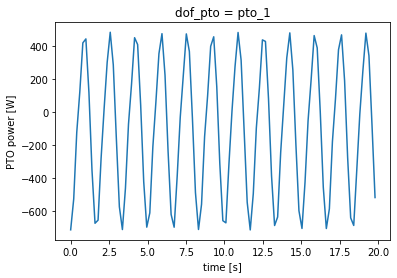

In [17]:
plt.figure()
wec_tdom['wave_elevation'].plot()

plt.figure()
wec_tdom['pos'].plot()

plt.figure()
pto_tdom['force'].plot()

plt.figure()
pto_tdom['power'].plot()

Next, we will look at some frequency-domain plots of the simulation results. 
Note that due to the non-linear constraint the PTO force contains higher frequencies, multiple of the excitation frequency. 
The unconstrained optimal solution would only contain one component at the excitation frequency.

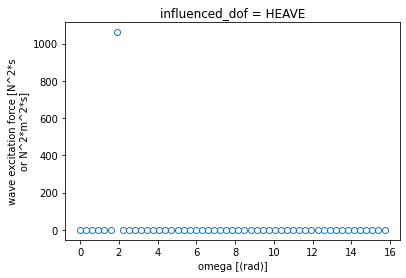

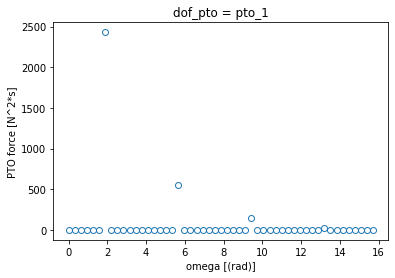

In [18]:
fd_lines = {'marker': 'o', 'linestyle': '', 'fillstyle': 'none'}

plt.figure()
np.abs(wec_fdom['excitation_force']).plot(**fd_lines)

plt.figure()
np.abs(pto_fdom['force']).plot(**fd_lines)

plt.show()

### Plotting Continuous Time
The pseudo-spectral method is a discrete-frequency but continuous time approach. 
The time-domain xarrays only contain the times corresponding to a inverse Fourier tranform of the complex amplitudes. 
This however might not be fine enough time discretization for plotting. 
We will now create more smooth plots. 

First let's plot the WEC position.

Text(0, 0.5, 'heave [m]')

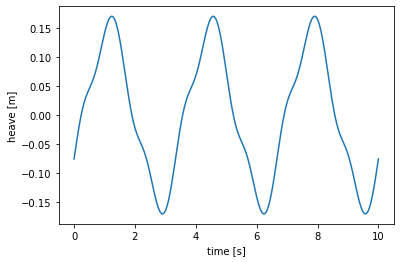

In [19]:
# create the continuous time function
pos = wec_fdom.pos.sel(influenced_dof="HEAVE")
fpos = wot.post_process_continuous_time(pos)

# fine time discretization
t = np.linspace(0, 10, 10000)

# plot
plt.figure()
plt.plot(t, fpos(t))

plt.xlabel('time [s]')
plt.ylabel('heave [m]')

Next, we will plot the PTO power, which looks very coarse when using the xarray results above. 
To calculate power in the time-domain we need to multiply the time-domain velocity and force.

Text(0, 0.5, 'power [W]')

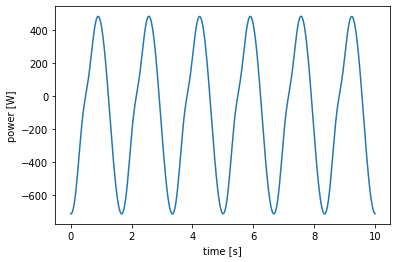

In [20]:
# create the continuous time functions
vel = pto_fdom.vel.sel(dof_pto="pto_1")
fvel = wot.post_process_continuous_time(vel)

force = pto_fdom.force.sel(dof_pto="pto_1")
fforce = wot.post_process_continuous_time(force)

def fpower(t):
    return fvel(t) * fforce(t)

# plot
plt.figure()
plt.plot(t, fpower(t))

plt.xlabel('time [s]')
plt.ylabel('power [W]')


## Comparison to Unconstained Case
The unconstrained (no maximum PTO force) optimal control can be calculated analytically as the conjugate gradient of the intrinsic impedance. 
We will compare the two results to gain some insight into the effect of the constraint on the optimal PTO force.

We will look at comparisons in both the time- and frequency-domain. 
Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of $2000 N$. 
Also note that the unconstrained optimal PTO force uses only one component at the excitation frequency, while the optimal constrained solution also contains components at odd multiples of the excitation frequency. 

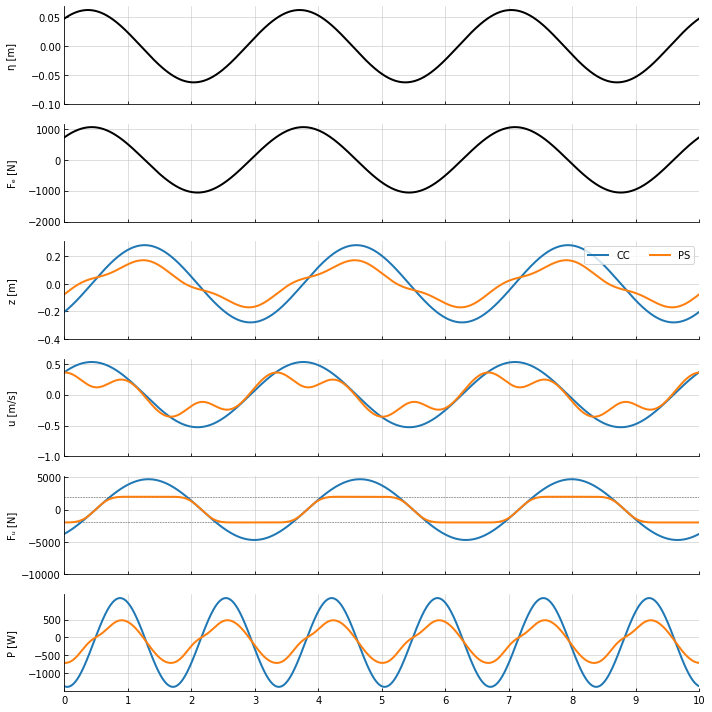

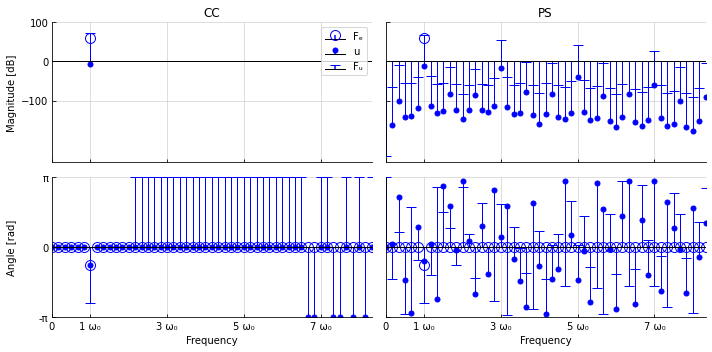

In [21]:
# CC solution
idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]
omega = Zi.omega

cc_vel_fd = Fe / (2*Zi.real)
cc_pos_fd = cc_vel_fd / (1j*omega)
cc_force_fd = -1.0 * Zi.conj() * cc_vel_fd

cc_pos_td = wot.post_process_continuous_time(cc_pos_fd)
cc_vel_td = wot.post_process_continuous_time(cc_vel_fd)
cc_force_td = wot.post_process_continuous_time(cc_force_fd)


def cc_power_td(t):
    return cc_force_td(t) * cc_vel_td(t) 


cc_pos_fd = np.concatenate([[0.0], cc_pos_fd])
cc_vel_fd = np.concatenate([[0.0], cc_vel_fd])
cc_force_fd = np.concatenate([[0.0], cc_force_fd])

# excitation force
Fe = wec_fdom['excitation_force'][:, idof]

# continuous time functions
t = np.linspace(0, 10, 10000)

elev = wec_fdom['wave_elevation']
felev = wot.post_process_continuous_time(elev)

exc = wec_fdom['excitation_force'].sel(influenced_dof='HEAVE')
fexc = wot.post_process_continuous_time(exc)

pos = wec_fdom.pos.sel(influenced_dof="HEAVE")
fpos = wot.post_process_continuous_time(pos)

vel = wec_fdom.vel.sel(influenced_dof="HEAVE")
fvel = wot.post_process_continuous_time(vel)

force = pto_fdom.force.sel(dof_pto="pto_1")
fforce = wot.post_process_continuous_time(force)


def fpower(t):
    return fvel(t) * fforce(t)


# plot 
ncases = 2

label_cc = 'CC'
label_ps = 'PS'
color_cc = 'tab:blue'
color_ps = 'tab:orange'
color_w = '0.0'
color_s = '0.25'
lw = 2

# Plot time domain
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(10, 10))

# plot PS force limits
xlim = 10.0
axs[4].plot([0.0, xlim], [f_max, f_max], '--', c=color_s, lw=0.5)
axs[4].plot([0.0, xlim], [-f_max, -f_max], '--', c=color_s, lw=0.5)

# plot wave 
axs[0].plot(t, felev(t), color=color_w, lw=lw)
axs[1].plot(t, fexc(t), color=color_w, lw=lw)

# plot CC 
axs[2].plot(t, cc_pos_td(t), color=color_cc, label=label_cc, lw=lw)
axs[3].plot(t, cc_vel_td(t), color=color_cc, label=label_cc, lw=lw)
axs[4].plot(t, cc_force_td(t), color=color_cc, label=label_cc, lw=lw)
axs[5].plot(t, cc_power_td(t), color=color_cc, label=label_cc, lw=lw)

# plot PS
axs[2].plot(t, fpos(t), color=color_ps, label=label_ps, lw=lw)
axs[3].plot(t, fvel(t), color=color_ps, label=label_ps, lw=lw)
axs[4].plot(t, fforce(t), color=color_ps, label=label_ps, lw=lw)
axs[5].plot(t, fpower(t), color=color_ps, label=label_ps, lw=lw)

# format subplots
ylims = [0.05, 1000.0, 0.2, 0.5, 5000.0, 500.0]
names = ['η [m]', 'Fₑ [N]', 'z [m]', 'u [m/s]',
         'Fᵤ [N]', 'P [W]']
for ax, ylim, name in zip(axs, ylims, names):
    ax.set_title('')
    if ax is not axs[-1]:
        ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.label_outer()
    ax.set_xticks([i for i in range(int(xlim)+1)], minor=False)
    ax.grid(color='0.75', linestyle='-', linewidth=0.5, which='major')
    ax.tick_params(direction='in')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0.0, xlim])
    ax.set_yticks([-2*ylim, -ylim, 0, ylim], minor=False)
axs[2].legend(ncol=ncases, loc='upper right')

fig.align_ylabels(axs)
fig.tight_layout()


## Plot frequency domain
omega = np.concatenate([[0.0], wec.omega])
cases = [label_cc, label_ps]

fig, axs = plt.subplots(2, ncases, sharex='col', sharey='row', figsize=(10, 5))


def plot_fd(axs, omega, fdom, marker, label, rmface=False):

    def _plot_fd(ax, omega, fdom, marker, label, rmface=False):
        markers, stems, base = ax.stem(
            omega,
            fdom,
            basefmt='k-',
            linefmt='b-',
            markerfmt='b'+marker,
            label=label)
        width = 1.0
        stems.set_linewidth(width)
        base.set_linewidth(width)
        markers.set_markeredgewidth(width)
        markers.set_markersize(10)
        if rmface:
            markers.set_markerfacecolor('none')

    omega = omega / (wfreq*2*np.pi)
    mag = np.squeeze(20*np.log10(np.abs(fdom),
                     out=np.ones(fdom.shape)*np.nan, where=fdom != 0))
    ang = np.squeeze(np.angle(fdom))

    _plot_fd(axs[0], omega, mag, marker, label, rmface)
    _plot_fd(axs[1], omega, ang, marker, label, rmface)


iaxs = axs[:, 0]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, cc_vel_fd, '.', 'u')
plot_fd(iaxs, omega, cc_force_fd, '_', 'Fᵤ')

iaxs = axs[:, 1]
plot_fd(iaxs, omega, Fe, 'o', 'Fₑ', True)
plot_fd(iaxs, omega, wec_fdom['vel'], '.', 'u')
plot_fd(iaxs, omega, pto_fdom['force'], '_', 'Fᵤ')

# format subplots
locs = [1, 3, 5, 7]
ylims = [100.0, np.pi]
xlims = [0, omega[-1]/(wfreq*2*np.pi)]
for i in range(ncases):
    iaxs = axs if ncases == 1 else axs[:, i]
    for j in range(2):
        iaxs[j].set_xticks([0]+locs, minor=False)
        iaxs[j].set_yticks([-ylims[j], 0, ylims[j]], minor=False)
        iaxs[j].label_outer()
        iaxs[j].grid(color='0.75', linestyle='-',
                     linewidth=0.5, which='major')
        iaxs[j].tick_params(direction='in')
        iaxs[j].spines['right'].set_visible(False)
        iaxs[j].spines['top'].set_visible(False)
        iaxs[j].set_xlim(xlims)
        iaxs[j].set_xticklabels(['0']+[f'{k} ω₀' for k in locs])
    iaxs[1].set_yticklabels(["-π", 0, "π"], minor=False)
    iaxs[0].set_title(cases[i])
    iaxs[1].set_xlabel('Frequency')
    iaxs[1].set_ylim([-np.pi, np.pi])
    if i == 0:
        iaxs[0].legend(ncol=1, loc='upper right')
        iaxs[0].set_ylabel('Magnitude [dB]')
        iaxs[1].set_ylabel('Angle [rad]')
        fig.align_ylabels(iaxs)

fig.tight_layout()
